In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [2]:
high_popularity_data = pd.read_csv(r"D:\Gamaka ai\ML lecture recording\Data Set for ML\archive\high_popularity_spotify_data.csv")

low_popularity_data = pd.read_csv(r"D:\Gamaka ai\ML lecture recording\Data Set for ML\archive\low_popularity_spotify_data.csv")


In [3]:
# Combine datasets
data = pd.concat([high_popularity_data, low_popularity_data], ignore_index=True)


In [4]:
# Data Cleaning

#  Remove unnecessary columns
columns_to_drop = ['track_href', 'uri', 'analysis_url', 'id', 'type']
data = data.drop(columns=columns_to_drop, errors='ignore')

In [5]:
# 🔹 Handle missing values by dropping rows with nulls
data = data.dropna()


In [6]:
#  Identify categorical columns
categorical_columns = ['playlist_genre', 'playlist_subgenre', 'track_artist', 'track_album_name', 'playlist_name']


In [7]:
#  Encode categorical columns using Label Encoding
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le


 # Exploratory Data Analysis (EDA)



In [8]:
# Check distribution of target variable (Popularity)
data['is_repeated'] = (data['track_popularity'] > 50).astype(int)


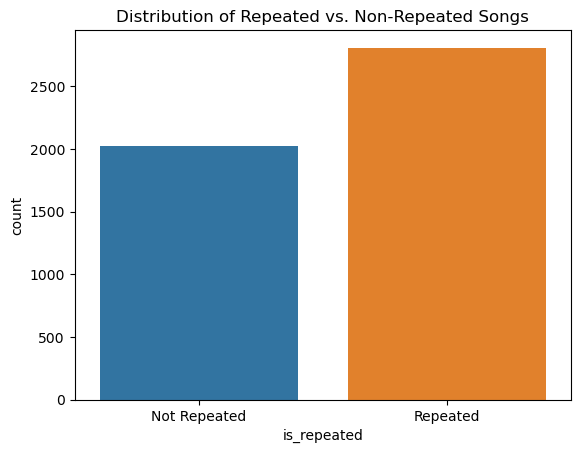

In [9]:
sns.countplot(x=data['is_repeated'])
plt.title("Distribution of Repeated vs. Non-Repeated Songs")
plt.xticks([0, 1], ["Not Repeated", "Repeated"])
plt.show()

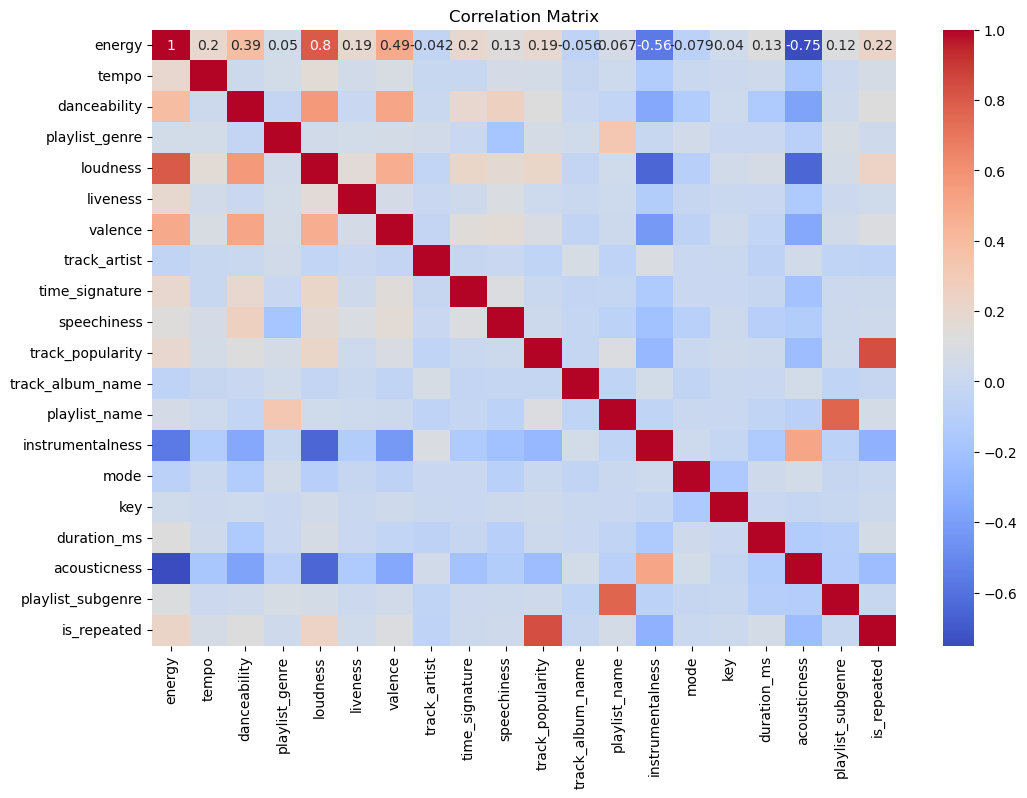

In [10]:
# Correlation Heatmap (Only Numeric Features)
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True, annot=True)
plt.title("Correlation Matrix")
plt.show()

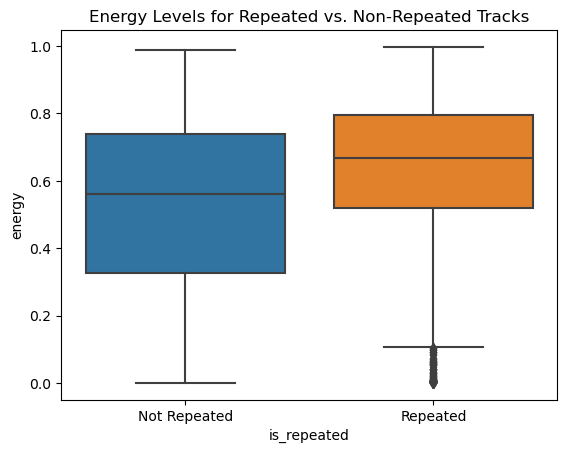

In [11]:
# Boxplot: Energy vs. Popularity
sns.boxplot(x=data['is_repeated'], y=data['energy'])
plt.title("Energy Levels for Repeated vs. Non-Repeated Tracks")
plt.xticks([0, 1], ["Not Repeated", "Repeated"])
plt.show()

In [12]:
#  Define Features and Target
X = data.drop(['track_popularity', 'is_repeated'], axis=1)  # Features
y = data['is_repeated']  # Target

In [13]:
#  Split Data into Training & Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
#  Apply StandardScaler
scaler = StandardScaler()

# Identify non-numeric columns
non_numeric_columns = X_train.select_dtypes(include=['object']).columns

# Ensure all categorical columns are encoded properly
for column in non_numeric_columns:
    if column not in label_encoders:  # Prevent KeyError if column was not encoded before
        le = LabelEncoder()
        X_train[column] = le.fit_transform(X_train[column].astype(str))
        X_test[column] = X_test[column].astype(str).map(lambda s: le.classes_.tolist().index(s) if s in le.classes_ else -1)
        label_encoders[column] = le  # Store encoder for future use
    else:
        le = label_encoders[column]
        X_train[column] = X_train[column].astype(str).map(lambda s: le.classes_.tolist().index(s) if s in le.classes_ else -1)
        X_test[column] = X_test[column].astype(str).map(lambda s: le.classes_.tolist().index(s) if s in le.classes_ else -1)

# Ensure all features are numeric
print("Checking data types after encoding:\n", X_train.dtypes)

# Apply StandardScaler only to numeric data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Checking data types after encoding:
 energy                      float64
tempo                       float64
danceability                float64
playlist_genre                int32
loudness                    float64
liveness                    float64
valence                     float64
track_artist                  int32
time_signature              float64
speechiness                 float64
track_album_name              int32
playlist_name                 int32
track_id                      int32
track_name                    int32
track_album_release_date      int32
instrumentalness            float64
track_album_id                int32
mode                        float64
key                         float64
duration_ms                 float64
acousticness                float64
playlist_subgenre             int32
playlist_id                   int32
dtype: object


In [15]:
#  Step 8: Train the Machine Learning Model (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
# Step 9: Evaluate Model Performance
y_pred = model.predict(X_test)

print("\n Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



 Model Performance:
Accuracy: 0.8364389233954451
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.72      0.79       399
           1       0.83      0.92      0.87       567

    accuracy                           0.84       966
   macro avg       0.84      0.82      0.83       966
weighted avg       0.84      0.84      0.83       966



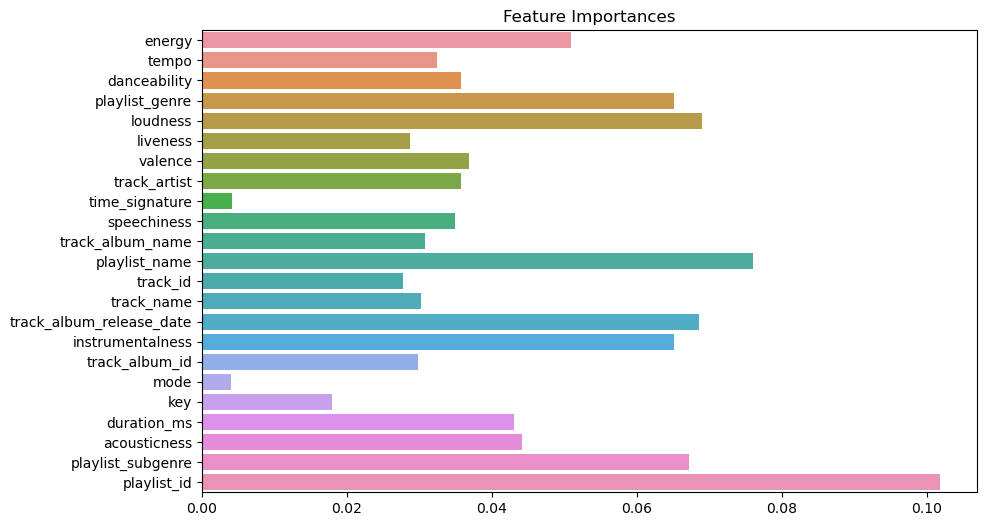

In [17]:
# Identify Feature Importance
feature_importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title("Feature Importances")
plt.show()

In [18]:
#  Generate Song Recommendations
def recommend_songs(new_tracks_df):
    """ Function to predict the probability of a song being repeated """
    
    # Encode categorical features using stored LabelEncoders
    for column in non_numeric_columns:
        le = label_encoders[column]
        new_tracks_df[column] = new_tracks_df[column].astype(str).map(lambda s: le.classes_.tolist().index(s) if s in le.classes_ else -1)

    # Scale the numerical features
    new_tracks_scaled = scaler.transform(new_tracks_df)

    # Predict probabilities
    recommendations = model.predict_proba(new_tracks_scaled)[:, 1]

    # Add recommendation scores
    new_tracks_df['recommendation_score'] = recommendations

    # Sort by highest probability
    recommended_songs = new_tracks_df.sort_values(by='recommendation_score', ascending=False)
    
    return recommended_songs[['track_name', 'recommendation_score']]

# Example: Provide a DataFrame of new songs to test recommendations
# new_songs = pd.DataFrame({...})  # Add new track details
# print(recommend_songs(new_songs))

Conclusion: The data reveals a clear distinction between repeated and non-repeated songs based on features like track popularity, energy, and genre. Songs with higher popularity and energy tend to be repeated more often. The correlations suggest that attributes like danceability and loudness also play a significant role in determining song popularity.